In [678]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

# plotting/mapmaknig/
import geopandas as gpd
from geospatial_functions import get_background_map
import rasterio
from rasterio.plot import show as rioshow

import warnings

import time

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'
gis_folder = f'{home_path}\\GIS'

In [591]:
files = glob.glob(f"{data_folder}\\*.parquet")
all_data = pd.read_parquet(files[0])

In [70]:
# loading other layers
outline           = gpd.read_file(f"{gis_folder}\\hudson_basin_26918.gpkg",driver="GPKG",crs="EPSG:26918")
main_rivers       = gpd.read_file(f"{gis_folder}\\main_rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
all_rivers        = gpd.read_file(f"{gis_folder}\\rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
gdf_thiessen      = gpd.read_file(f'{gis_folder}\\Thiessen_prcp.shp',crs="EPSG:26918")
# fixing crs
for layer in [outline,main_rivers,all_rivers, gdf_thiessen]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

In [25]:
files = glob.glob(f"{data_folder}\\P\\data per station\\*_prcp.csv")

## Load in all precipitaion data

In [440]:
df_lst_input = []
station_lst = []
station_index_dict= {}
for index, file in enumerate(files):
    df = pd.read_csv(file, index_col='DATE', usecols=['DATE', 'PRCP', 'STATION', 'LATITUDE', 'LONGITUDE'],  delimiter=',', parse_dates=True)
    station_lst.append([df.iloc[0].STATION,df.iloc[0].LATITUDE, df.iloc[0].LONGITUDE])
    df_lst_input.append(df)
    station_index_dict[f"{df.iloc[0].STATION}"] = index

###  turn this into a dataframe with stations

In [417]:
station_arr = np.array(station_lst)
df_stations = pd.DataFrame(data = list(zip(station_arr[:,0], station_arr[:,1],station_arr[:,2])),columns = ['STATION', 'LATITUDE', 'LONGITUDE'],)
gdf_stations = gpd.GeoDataFrame(data=df_stations, geometry=gpd.points_from_xy(df_stations.LONGITUDE,df_stations.LATITUDE), crs="EPSG:4326")

In [418]:
gdf_stations_in_area = gdf_stations[gdf_stations.within(outline.iloc[0].geometry)]

<AxesSubplot: >

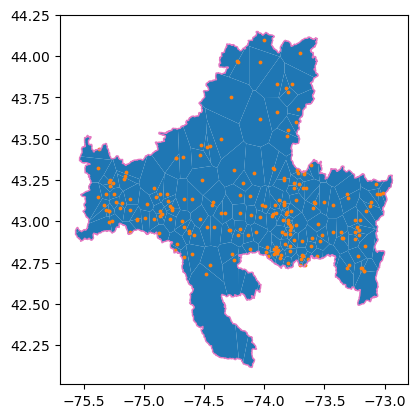

In [419]:
fig, ax = plt.subplots(1)

gdf_thiessen.plot(ax=ax)
gdf_stations_in_area.plot(ax=ax,color="C1",markersize=3) .plot()
outline.plot(ax=ax,edgecolor="C6",facecolor="None")

### perform spatial join to comine the two

In [81]:
gdf_joined = gdf_stations_in_area.sjoin(gdf_thiessen)
gdf_joined.head(5)

STATION   LATITUDE   LONGITUDE                    geometry  \
0   US1MABE0018   42.70054   -73.16939  POINT (-73.16939 42.70054)   
16  US1NYAB0037  42.768644  -73.691117  POINT (-73.69112 42.76864)   
20  US1NYES0005  43.808639  -73.818869  POINT (-73.81887 43.80864)   
21  US1NYES0006    43.8335   -73.89775  POINT (-73.89775 43.83350)   
26  US1NYFL0007  43.039401  -74.108452  POINT (-74.10845 43.03940)   

    index_right  fid  field_1_1   station ID        lat        lon     area  
0           155  582        581  US1MABE0018  42.700540 -73.169390   61.916  
16          174  647        646  US1NYAB0037  42.768644 -73.691117   12.968  
20            2   41         40  US1NYES0005  43.808639 -73.818869   53.159  
21            3   47         46  US1NYES0006  43.833500 -73.897750  296.634  
26          202  779        778  US1NYFL0007  43.039401 -74.108452   82.854

weigh the contributions of both

In [441]:
lst_dfs_concat = []
for i in gdf_joined.index:
    station_name = gdf_joined.loc[i,"STATION"]
    station_area = gdf_joined.loc[i,"area"]
    df = df_lst_input[station_index_dict[station_name]][["PRCP"]].copy()
    df.rename(columns={'PRCP':f'{station_name}'},inplace=True)
    lst_dfs_concat.append(df)

In [442]:
df_combined = pd.concat(lst_dfs_concat, axis=1)

The issue is, not all stations overlap, only 4 stations stand between 1950 and 2020, to combat this, we create thiessen polygons for all combinations of stations

In [657]:
n_year = 5 # threshold for the number of years to be opperating
df_selected_combined = df_combined.loc["1950":"2020"].dropna(axis=1,thresh=365*n_year)

In [658]:
df_selected_combined

US1NYES0005  US1NYES0006  US1NYHR0012  US1NYMG0001  US1NYMG0002  \
DATE                                                                          
1950-01-01          NaN          NaN          NaN          NaN          NaN   
1950-01-02          NaN          NaN          NaN          NaN          NaN   
1950-01-03          NaN          NaN          NaN          NaN          NaN   
1950-01-04          NaN          NaN          NaN          NaN          NaN   
1950-01-05          NaN          NaN          NaN          NaN          NaN   
...                 ...          ...          ...          ...          ...   
2020-12-27          0.5          0.8          1.3          0.0          0.0   
2020-12-28          0.3          0.3          0.0          0.0          0.3   
2020-12-29          1.8          2.5          1.3          0.5          0.3   
2020-12-30          0.0          0.0          0.0          0.0          0.8   
2020-12-31          0.5          2.0         14.2          1.3          0.0   

            US1NYOD0007  US1NYOD0019  US1NYOD0042  US1NYOD0043  US1NYSC0002  \
DATE                                                                          
1950-01-01          NaN          NaN          NaN          NaN          NaN   
1950-01-02          NaN          NaN          NaN          NaN          NaN   
1950-01-03          NaN          NaN          NaN          NaN          NaN   
1950-01-04          NaN          NaN          NaN          NaN          NaN   
1950-01-05          NaN          NaN          NaN          NaN          NaN   
...                 ...          ...          ...          ...          ...   
2020-12-27          NaN          0.0          NaN          1.3          NaN   
2020-12-28          NaN          0.8          NaN          0.3          0.0   
2020-12-29          NaN          6.6          NaN          1.8          0.0   
2020-12-30          NaN          0.0          NaN          0.0          0.0   
2020-12-31          NaN          5.1          NaN          4.1          4.6   

            ...  USC00431786  USC00434882  USC00436500  USC00438160  \
DATE        ...                                                       
1950-01-01  ...          0.0          NaN          NaN          NaN   
1950-01-02  ...          0.0          NaN          NaN          NaN   
1950-01-03  ...          6.4          NaN          NaN          NaN   
1950-01-04  ...          0.0          NaN          NaN          NaN   
1950-01-05  ...          2.5          NaN          NaN          NaN   
...         ...          ...          ...          ...          ...   
2020-12-27  ...          NaN          NaN          NaN          NaN   
2020-12-28  ...          NaN          NaN          NaN          NaN   
2020-12-29  ...          NaN          NaN          NaN          NaN   
2020-12-30  ...          NaN          NaN          NaN          NaN   
2020-12-31  ...          NaN          NaN          NaN          NaN   

            USW00004782  USW00014735  USW00014750  USW00054768  USW00054781  \
DATE                                                                          
1950-01-01          0.0          0.0          0.0          NaN          NaN   
1950-01-02          0.5          1.5          0.3          NaN          NaN   
1950-01-03          0.0          0.3          1.8          NaN          NaN   
1950-01-04          0.0          0.0          3.8          NaN          NaN   
1950-01-05          1.5          2.3          0.0          NaN          NaN   
...                 ...          ...          ...          ...          ...   
2020-12-27          NaN          0.0          0.0          0.0          0.0   
2020-12-28          NaN          0.0          0.3          0.0          0.0   
2020-12-29          NaN          0.0          0.0          0.0          0.0   
2020-12-30          NaN          0.5          0.0          2.8          2.3   
2020-12-31          NaN          0.8          0.5          5.6          3.6   

    

In [659]:
df_selected_combined.iloc[:10].apply(lambda x: np.isnan([x.loc[col] for col in x.index])).sum(axis=1)

DATE
1950-01-01    49
1950-01-02    48
1950-01-03    48
1950-01-04    47
1950-01-05    47
1950-01-06    47
1950-01-07    47
1950-01-08    47
1950-01-09    47
1950-01-10    47
dtype: int64

In [660]:
count_nans = df_selected_combined.apply(lambda x: np.isnan([x.loc[col] for col in x.index])).sum(axis=1)

Text(0.5, 1.0, 'Amount of opperating stations')

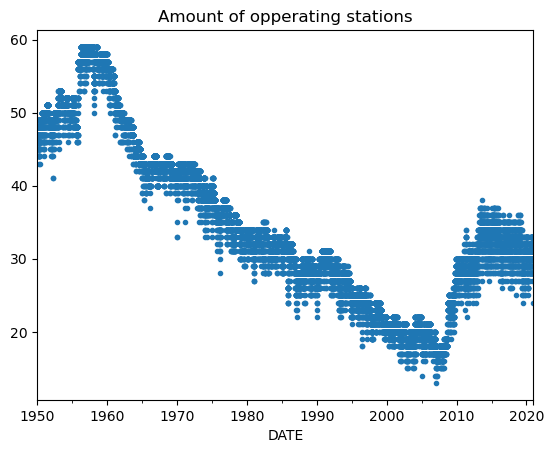

In [661]:
(len(df_selected_combined.columns)- count_nans).plot(lw=0,marker=".")
plt.title("Amount of opperating stations")

In [662]:
columns = np.array(df_selected_combined.columns.to_list())
series_stations_not_na_txt = df_selected_combined.apply(lambda x: ','.join(columns[~np.isnan([x.loc[col] for col in x.index])]),axis=1)
df_stations_not_na_txt = pd.DataFrame(data=series_stations_not_na_txt,columns=["names_station"])
# df_stations_not_na_txt.apply(lambda x: len(x.names_station),axis=1).plot()
len(df_stations_not_na_txt["names_station"].unique())

5844

even with a threshold of 60 years there are already 70. 
>with 50 years per station, there are 478 combinations of stations.<br>
>with 20 there are 2609<br>
>with 10 there are 5844

ajust the n_years parameter to change this, for the purpose of this nb, 70years is taken

**first compute for all combinations of stations**

In [677]:

start = time.time()

In [669]:
series_stations_not_na_ids = df_selected_combined.apply(lambda x: columns[~np.isnan([x.loc[col] for col in x.index])],axis=1)
df_stations_not_na_ids = pd.DataFrame(data=series_stations_not_na_ids,columns=["names_station"])

In [670]:
from longsgis import voronoiDiagram4plg
def draw_thiessen_polygons(stations, boundary):
    """https://pypi.org/project/voronoi-diagram-for-polygons/"""
    warnings.filterwarnings("ignore", category=FutureWarning)
    vd = voronoiDiagram4plg(stations, boundary)
    return vd

In [671]:
total_area = outline.to_crs("EPSG:26918").area.sum()
lst_df_joined = []
dict_df_joined = {}
for index, combination in enumerate(df_stations_not_na_txt['names_station'].unique()):
    ids_to_thiessen = combination.split(",")
    df_station_to_thiessen = gdf_stations_in_area.set_index("STATION").loc[ids_to_thiessen]
    thiessen_polygons = draw_thiessen_polygons(df_station_to_thiessen, outline)
    thiessen_polygons = thiessen_polygons.to_crs("epsg:26918")
    df_station_to_thiessen = df_station_to_thiessen.to_crs("epsg:26918")
    thiessen_polygons["Area_m2"] = thiessen_polygons.area
    df_joined = df_station_to_thiessen.sjoin(thiessen_polygons)
    
    # save the outputs to be used later, dict to get the index, list to store the data
    lst_df_joined.append(df_joined)
    dict_df_joined[combination] = index

KeyboardInterrupt: 

In [ ]:
len(lst_df_joined)

The dict and list contain all the combinations: thus we then call these when looping over all the days

In [ ]:
df_weighted_rain = pd.DataFrame(columns=["P"])
for date, row in df_stations_not_na_txt.iterrows():
    combination_stations = row["names_station"]
    P = lst_df_joined[dict_df_joined[combination_stations]].apply(lambda x: df_lst_input[station_index_dict[x.name]].loc[date, "PRCP"] *x["Area_m2"] /total_area,axis=1).sum()
    df_weighted_rain.loc[date,"P"] = P

In [ ]:
fig, ax = plt.subplots(1)
df_weighted_rain["P"].plot(ax=ax,label="weighted theissen",marker=".",lw=0)
all_data["P"].plot(ax=ax,label="mean over area (previous)",alpha=0.5,lw=0,marker=".")
ax.legend()
ax.set_xlim(["1950","2020"])

In [676]:
end = time.time()
end

AttributeError: 'str' object has no attribute 'time'

In [673]:
print(time)

1653293313.7861013min for 5 threshold of observations


the peaks seem better represented

In [644]:
output = False
if output:
    df_weighted_rain.to_parquet(f"{data_folder}\\P\\weighted_average_P_{n_years}.parquet")

example of thiessen polygons:

<AxesSubplot: >

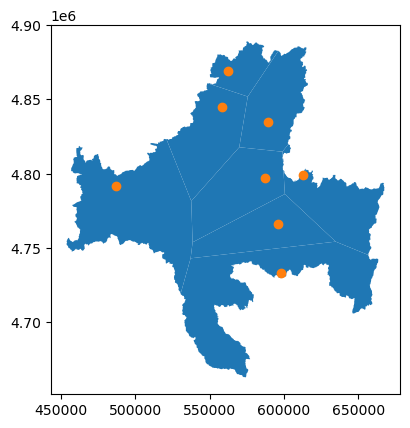

In [625]:
ax = df_station_to_thiessen.plot(color="C1",zorder=10)
thiessen_polygons.plot(ax=ax)

Plot of data start vs dat end

In [623]:
lst_extent = []
for df in df_lst:
    lst_extent.append([df.index.min(),df.index.max()])

Text(0, 0.5, 'end date')

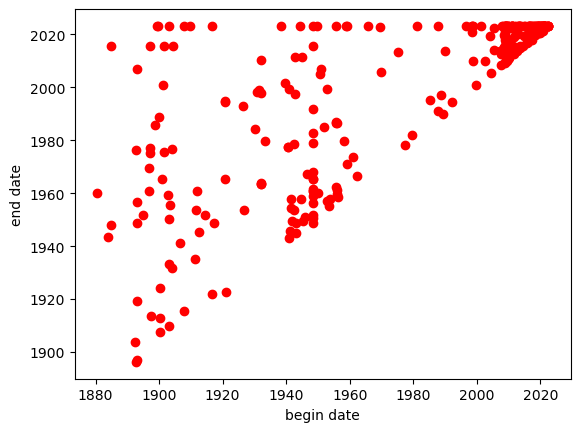

In [641]:
arr_extent = np.array(lst_extent)
plt.plot(arr_extent[:,0], arr_extent[:,1],"ro")
plt.xlabel("begin date")
plt.ylabel("end date")